In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from typing import List, Tuple
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('modules')

# Overview of the Notebook

This notebook is designed to provide an in-depth understanding of the kinematic bicycle model, a foundational concept in autonomous vehicle control and robotics. The notebook will cover:

- A detailed explanation of the kinematic bicycle model.
- Implementation and simulation of the model.
- Introduction to various control methods, including Proportional (P), Proportional-Integral (PI), Proportional-Integral-Derivative (PID), Stanley, Pure Pursuit, and Model Predictive Control (MPC).
- Comparison and analysis of different control methods using the kinematic bicycle model.

# Kinematic Bicycle Model Explained

The kinematic bicycle model is a simple and widely-used representation of a vehicle for control and simulation purposes. It captures the essential geometry and kinematics of a car-like vehicle, ignoring the dynamics or forces involved.

## Features of the Kinematic Bicycle Model

- **Wheelbase ($L$)**: The distance between the front and rear axles of the vehicle.
- **Distance from Rear Wheel to CG ($l_r$)**: The distance from the rear wheel to the center of gravity.
- **Velocity ($v$)**: The linear velocity of the vehicle.
- **Position ($x, y$)**: The 2D position of the vehicle in a global coordinate frame.
- **Heading Angle ($\theta$)**: The angle between the vehicle's orientation and the positive X-axis.
- **Slip Angle ($\beta$)**: The angle between the actual velocity vector and the orientation of the vehicle.
- **Steering Angle ($\delta$)**: The angle at which the front wheels are steered.

## Why Use the Kinematic Bicycle Model Over More Complex Models?

The kinematic bicycle model is often chosen over more complex models like the dynamic bicycle model or Ackermann model for several key reasons:

1. **Simplicity**: The kinematic bicycle model focuses solely on the geometric and kinematic aspects of the vehicle, ignoring the forces and dynamics. This makes it easier to understand, implement, and analyze.

2. **Computational Efficiency**: The absence of dynamic considerations in the kinematic bicycle model makes it computationally less demanding, especially when running simulations or optimizations over long time horizons.

3. **Suitable for High-Level Control**: For tasks that require high-level control decisions, such as path planning and trajectory optimization, the kinematic model's simplicity often suffices. The detailed dynamics may not significantly affect these high-level tasks.

4. **Ideal for Certain Environments and Conditions**: The kinematic bicycle model is particularly useful in scenarios where the effects of forces and torques (e.g., tire forces) are minimal or can be neglected. This includes low-speed maneuvers, smooth trajectories, or situations where detailed force modeling is not critical.


## Implementation of the Model

The following Python class `KinematicBicycleModel` encapsulates the kinematic bicycle model. It includes methods for initializing the state, getting the current state, simulating the model for one time step, and resetting the model:

In [2]:
class KinematicBicycleModel:
    """
    Kinematic Bicycle Model class.
    This model represents the kinematic behavior of the vehicle, which means it's primarily concerned with geometry and not the forces or dynamics.
    It assumes that the vehicle can change its velocity instantaneously, so it directly requires the new velocity v as an input to compute the next state.
    """
    def __init__(self, L: float = 2.0, lr: float = 1.2, dt: float = 0.01):
        self.L: float = L  # Wheelbase
        self.lr: float = lr  # Distance from rear wheel to CG
        self.dt: float = dt  # Time step
        self.v: float = 0.0  # Initial velocity
        self.x: float = 0.0  # Initial position x
        self.y: float = 0.0  # Initial position y
        self.theta: float = 0.0  # Heading angle
        self.beta: float = 0.0  # Slip angle
        self.delta: float = 0.0  # Steering angle
        self.max_delta: float = np.radians(30)  # Maximum steering angle

    def initialize(self, x: float = 0.0, y: float = 0.0, theta: float = 0.0, v: float = 0.0, delta: float = 0.0, beta: float = 0.0) -> None:
        """Initialize the state of the vehicle."""
        self.x = x
        self.y = y
        self.theta = theta
        self.v = v
        self.delta = delta
        self.beta = beta

    def get_state(self) -> tuple[float, float, float, float, float, float]:
        """Return the current state of the vehicle."""
        return (self.x, self.y, self.theta, self.v, self.delta, self.beta)

    def step(self, v: float, delta: float) -> None:
        """Simulate the kinematic bicycle model for one time step."""
        self.x += v * np.cos(self.theta + self.beta) * self.dt
        self.y += v * np.sin(self.theta + self.beta) * self.dt
        self.theta += (v / self.L) * np.tan(delta) * self.dt
        self.v = v
        self.delta = delta
        self.beta = np.arctan(self.lr * np.tan(delta) / self.L)

    def reset(self) -> None:
        """Reset the state of the vehicle."""
        self.v = 0.0
        self.x = 0.0
        self.theta = 0.0
        self.y = 0.0
        self.beta = 0.0
        self.delta = 0.0


First, lets create an instance of the `KinematicBicycleModel` class and defining control inputs.  
Then we will simulate the model over a duration by repeatedly calling the `step` method.

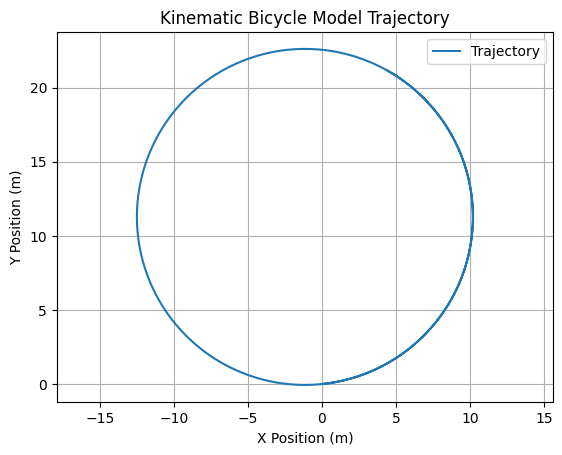

In [3]:
# Define simulation parameters
dt = 0.1  # Time step
time_duration = 100.0  # Simulation duration

# Initialize the model
model = KinematicBicycleModel(dt=dt)

# Define control inputs
v = 1.0  # Constant velocity (m/s)
delta = np.radians(10)  # Constant steering angle (degrees)


# Initialize the trajectory
x_trajectory = []
y_trajectory = []
# Simulate the model
for t in np.arange(0, time_duration, dt):
    x, y, _, _, _, _ = model.get_state()
    x_trajectory.append(x)
    y_trajectory.append(y)
    model.step(v, delta)

# Plotting the trajectory
plt.plot(x_trajectory, y_trajectory, label='Trajectory')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Kinematic Bicycle Model Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In the following we will be controlling the kinematic model along the following three trajectories.

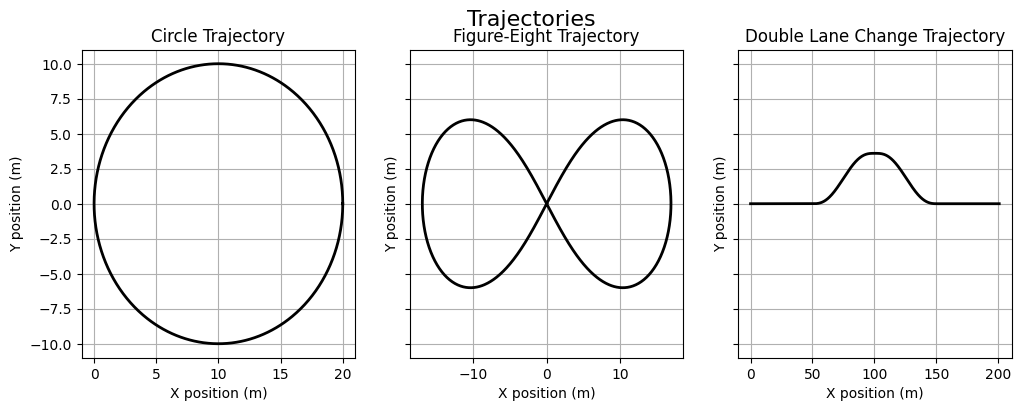

In [4]:
from modules.trajectories import total_distance, circle_trajectory, figure_eight_trajectory, double_lane_change_trajectory

# Reference Path Parameters #
NUM_POINTS = 1000
# Circle #
R = 10  # Radius of Circle
# Fig 8 #
A=12  # Diameter of Figure 8
# Double Lane Change #
LANE_WIDTH = 3.6
LANE_CHANGE_DISTANCE = 50
STRAIGHT_DISTANCE = 1


#--------#
# Circle #
circular_gt = circle_trajectory(R=R, num_points=NUM_POINTS)
simulation_steps = int(total_distance(circular_gt[0], circular_gt[1]) / (v * dt))

#----------#
# Figure 8 #
figure8_gt = figure_eight_trajectory(a=A, num_points=NUM_POINTS)
simulation_steps_fig8 = int(total_distance(figure8_gt[0], figure8_gt[1]) / (v * dt))
initial_theta = np.arctan2(figure8_gt[1][1] - figure8_gt[1][0], figure8_gt[0][1] - figure8_gt[0][0])

#--------------------#
# Double Lane Change #
double_gt = double_lane_change_trajectory(lane_width=LANE_WIDTH, lane_change_distance=LANE_CHANGE_DISTANCE, straight_distance=STRAIGHT_DISTANCE, num_points=NUM_POINTS)
simulation_steps_double = int(total_distance(double_gt[0], double_gt[1]) / (v * dt))



fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle(f'Trajectories', fontsize=16)

# Circle
ax[0].plot(circular_gt[0], circular_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle="-")
ax[0].set_title('Circle Trajectory')
ax[0].set_xlabel('X position (m)')
ax[0].set_ylabel('Y position (m)')
ax[0].grid(True)

# Figure 8
ax[1].plot(figure8_gt[0], figure8_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle="-")
ax[1].set_title('Figure-Eight Trajectory')
ax[1].set_xlabel('X position (m)')
ax[1].set_ylabel('Y position (m)')
ax[1].grid(True)

# Double Lane Change
ax[2].plot(double_gt[0], double_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle="-")
ax[2].set_title('Double Lane Change Trajectory')
ax[2].set_xlabel('X position (m)')
ax[2].set_ylabel('Y position (m)')
ax[2].grid(True)



# Control Methods

Control methods are algorithms that regulate the behavior of a system to achieve a desired output or follow a specified path. In the context of autonomous vehicles, control methods are used to govern the motion of the vehicle to follow a planned trajectory. This chapter explores various control methods applicable to the kinematic bicycle model.

## Proportional (P) Control

The Proportional Controller (P Controller) calculates the control effort by multiplying the error (difference between the setpoint and current state) by a proportional gain $ K_p $.

$$
\text{{Control Output}} = K_p \cdot \text{{error}}
$$

### Upsides and Downsides
* **Upsides**: Simple to implement and understand.
* **Downsides**: May lead to steady-state error; no integral or derivative action to handle accumulated errors or predict future errors.

## Proportional-Integral (PI) Control

The Proportional-Integral Controller (PI Controller) adds an integral term to the P Controller. The integral term accounts for the accumulated error over time, helping to reduce steady-state error.

$$
\text{{Control Output}} = K_p \cdot \text{{error}} + K_i \cdot \int \text{{error}} \, dt
$$


### Upsides and Downsides
* **Upsides**: Reduces steady-state error.
* **Downsides**: Can lead to overshooting and oscillations if not properly tuned.

## Proportional-Derivative (PD) Control

The Proportional-Derivative Controller (PD Controller) adds a derivative term to the P Controller. The derivative term predicts future errors by considering the rate of change of the error.

$$
\text{{Control Output}} = K_p \cdot \text{{error}} + K_d \cdot \frac{{d(\text{{error}})}}{{dt}}
$$

### Upsides and Downsides
* **Upsides**: Provides damping, reducing overshooting.
* **Downsides**: Does not eliminate steady-state error as it lacks an integral term.

## Proportional-Integral-Derivative (PID) Control

The Proportional-Integral-Derivative Controller (PID Controller) combines the P, I, and D terms, offering a balance between responsiveness, stability, and steady-state accuracy.

$$
\text{{Control Output}} = K_p \cdot \text{{error}} + K_i \cdot \int \text{{error}} \, dt + K_d \cdot \frac{{d(\text{{error}})}}{{dt}}
$$


### Upsides and Downsides
* **Upsides**: Versatile and widely used; can be tuned to achieve desired performance.
* **Downsides**: Requires careful tuning; can be sensitive to noise in the derivative term.

## Stanley Control

The Stanley Controller is designed for path tracking, particularly in autonomous driving. It calculates the steering angle by correcting both the cross-track error (distance from the reference path) and heading error (difference in orientation).

$$
\delta = \text{{heading error}} + \arctan \left( \frac{{k \cdot \text{{cte}} \cdot \text{{sign}}}}{{v}} \right)
$$

### Upsides and Downsides
* **Upsides**: Effective for path tracking; accounts for both position and orientation errors.
* **Downsides**: Requires careful tuning; specific to path-following tasks.

## Pure Pursuit Control

The Pure Pursuit Controller is a geometric path tracking algorithm that computes the steering angle based on a lookahead point on the reference path.

$$
\delta = \arctan \left( \frac{{2 \cdot \sin(\alpha)}}{{l_d}} \right)
$$

### Upsides and Downsides
* **Upsides**: Simple and robust; works well for path tracking.
* **Downsides**: May require tuning of the lookahead distance; assumes constant curvature within the lookahead distance.

## Model Predictive Control (MPC)

Model Predictive Control (MPC) is an advanced control method that optimizes the control inputs over a prediction horizon, considering constraints and a cost function. It leverages a mathematical model to predict future states and minimize the deviation from a reference trajectory.


### Upsides and Downsides
* **Upsides**: Can handle constraints; optimizes performance over a prediction horizon; versatile and powerful.
* **Downsides**: Computationally demanding; requires a mathematical model; may be complex to implement and tune.

In [5]:
from modules.controllers import PIDController, PController, PIController, StanleyController, PurePursuitController, MPC

## Auxiliary Methods

The provided auxiliary methods are essential for implementing and visualizing the trajectory control of the vehicle. They serve as supporting functions that enable the controllers to accurately follow a reference path. Let's break down the purpose and relevance of each method:

1. **`find_forward_nearest_point_segment`**: This function finds the nearest point on the path ahead of the vehicle. It ensures that the controller focuses on the segment of the path in front of the vehicle rather than any nearby points that might be behind it. This behavior is crucial for controllers like the Stanley Controller, which needs to minimize both cross-track error (CTE) and heading error.

2. **`find_nearest_point`**: This function identifies the nearest point on the reference path to the current vehicle position. It's a foundational function used by other methods and helps in computing errors like CTE, which is essential for path-following controllers.

3. **`visualize_nearest_points`**: This function provides a visualization of the driven path, the reference path, and the nearest points on the reference path corresponding to each point on the driven path. It helps in analyzing how well the controller is following the reference path and is useful for tuning and debugging the controllers.

4. **`compute_cross_track_error`**: Computing the CTE is essential for controllers like the Stanley Controller. CTE represents the perpendicular distance from the vehicle to the nearest point on the reference path. Minimizing CTE helps the vehicle stay on the desired trajectory.

5. **`compute_heading_error`**: The heading error represents the difference between the vehicle's current heading and the desired heading towards a lookahead point on the reference path. It is used in controllers that need to align the vehicle's orientation with the path direction.

### Visualization of Basic Controller Behaviors

To illustrate how the controllers utilize these auxiliary methods and their basic behaviors, we'll set up a scenario where each controller tries to follow a reference path. We'll create a reference path and simulate the controllers' behaviors over time, then visualize the results.

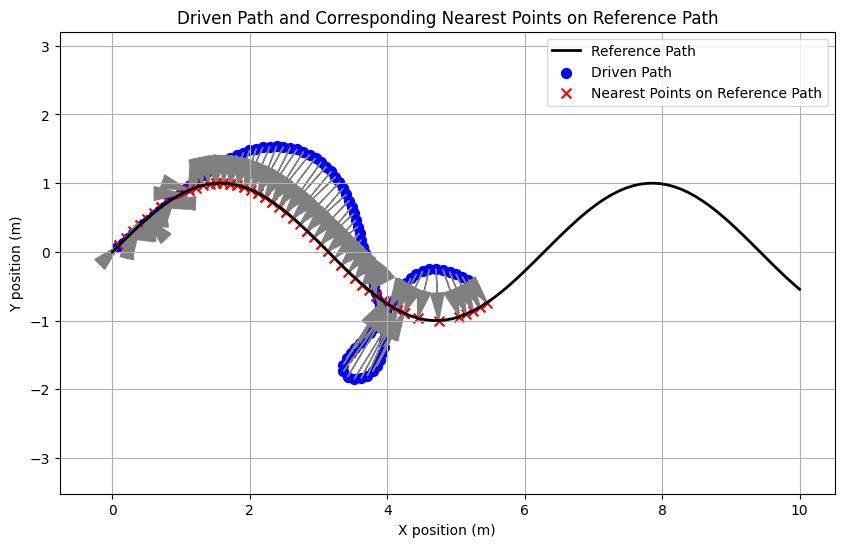

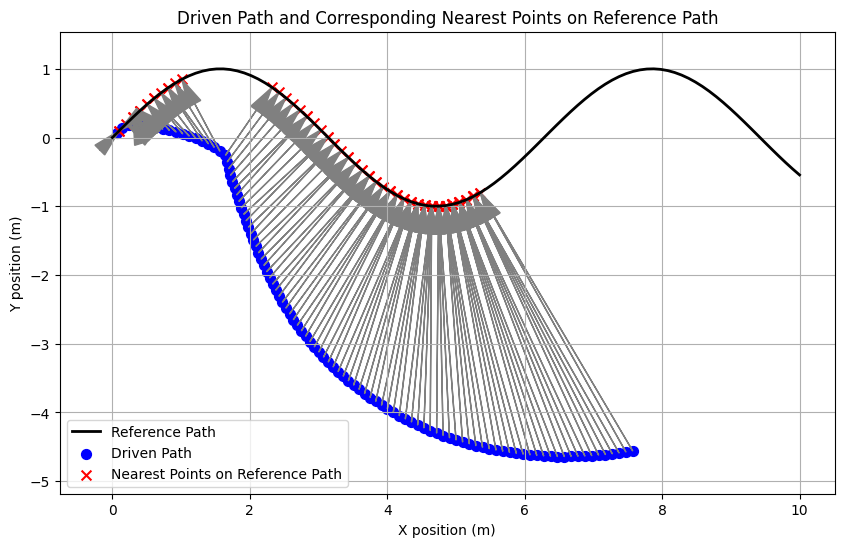

In [6]:
from modules.auxilliary import find_nearest_point, find_forward_nearest_point_segment, compute_cross_track_error, compute_heading_error, visualize_nearest_points

# Create a reference path (e.g., a simple curve)
reference_path_x = np.linspace(0, 10, 100)
reference_path_y = np.sin(reference_path_x)

# Initialize the Kinematic Bicycle Model
model = KinematicBicycleModel(dt=0.1)

# Create controllers
pi_controller = PIController(kp=0.95, ki=0.1, dt=model.dt)
stanley_controller = StanleyController(k=0.5)

# Define the starting state
initial_theta = np.arctan2(reference_path_y[1] - reference_path_y[0], reference_path_x[1] - reference_path_x[0])
start_state = (0, 0, initial_theta, 0, 0, 0)

# Simulate the P Controller
driven_path_x_p, driven_path_y_p = [], []
model.initialize(*start_state)
for i in range(len(reference_path_x)):
    nearest_idx, nearest_x, nearest_y = find_forward_nearest_point_segment(model.x, model.y, model.theta, reference_path_x, reference_path_y, segment_length=2)
    cte = compute_cross_track_error(model.x, model.y, nearest_x, nearest_y)
    delta = pi_controller.compute(0, cte) # Control based on CTE
    model.step(1, delta)
    driven_path_x_p.append(model.x)
    driven_path_y_p.append(model.y)
visualize_nearest_points(reference_path_x, reference_path_y, driven_path_x_p, driven_path_y_p)

# Simulate the Stanley Controller
driven_path_x_s, driven_path_y_s = [], []
model.initialize(*start_state)
for i in range(len(reference_path_x)):
    delta = stanley_controller.control((reference_path_x, reference_path_y), (model.x, model.y, model.theta))
    model.step(1, delta)
    driven_path_x_s.append(model.x)
    driven_path_y_s.append(model.y)
visualize_nearest_points(reference_path_x, reference_path_y, driven_path_x_s, driven_path_y_s)

These simulations and visualizations help to understand how different controllers behave in following a reference path. The PI Controller focuses on minimizing the CTE, whereas the Stanley Controller also considers the vehicle's heading. The auxiliary methods play a key role in computing the necessary errors and visualizing the performance, tying the entire control process together.

# Simulation

The following `simulate` function provides a unified and flexible framework to test various control strategies on the kinematic bicycle model. It integrates closely with the auxiliary methods used to calculate errors and find the nearest points, enabling a comprehensive and comparative analysis of different controllers. By providing support for different types of controllers and offering customization through additional arguments, it serves as a versatile tool for studying and tuning control strategies in the context of autonomous vehicle path tracking.

In [7]:
def simulate(model: KinematicBicycleModel, path_x: List[float], path_y: List[float], desired_speed: float, controller, num_steps: int, base_lookahead_distance: int = 1, **kwargs) -> List[Tuple[float, float, float, float, float, float]]:
    states: List[Tuple[float, float, float, float, float, float]] = [model.get_state()]
    
    for _ in tqdm(range(num_steps)):
        # Find the nearest point on the path
        nearest_idx, nearest_x, nearest_y = find_forward_nearest_point_segment(model.x, model.y, model.theta, path_x, path_y)
        
        # Dynamic lookahead point strategy based on vehicle's speed
        lookahead_distance = int(base_lookahead_distance * model.v)
        lookahead_idx = (nearest_idx + int(lookahead_distance)) % len(path_x)
        
        lookahead_x, lookahead_y = path_x[lookahead_idx], path_y[lookahead_idx]
        
        # Compute errors based on the lookahead point
        cte = compute_cross_track_error(model.x, model.y, lookahead_x, lookahead_y)
        heading_error = compute_heading_error(model.theta, model.x, model.y, lookahead_distance, path_x, path_y)
        
        # Refined error calculation combining heading and crosstrack errors
        steering_error = cte + heading_error
        
        # Compute the control actions using the specified controller
        if isinstance(controller, PIDController):
            delta = controller.compute(steering_error, 0)
        elif isinstance(controller, StanleyController):
            N = kwargs.get("N", 5)
            ref_path = [path_x[nearest_idx:nearest_idx+N], path_y[nearest_idx:nearest_idx+N]]
            delta = controller.control(ref_path, (model.x, model.y, model.theta))
        elif isinstance(controller, PurePursuitController):
            N = kwargs.get("N", 5)
            ref_path = list(zip(path_x[nearest_idx:nearest_idx+N], path_y[nearest_idx:nearest_idx+N]))
            delta = controller.control(ref_path, (model.x, model.y, model.theta))
        elif isinstance(controller, MPC):
            N = controller.n_horizon
            ref_path = list(zip(path_x[nearest_idx:nearest_idx+N], path_y[nearest_idx:nearest_idx+N]))
            # Check if ref_path has less than N entries and pad if necessary
            while len(ref_path) < N:
                ref_path.append(ref_path[-1])  # Append the last point to pad
            ref_path = np.asarray(ref_path)
            controller.x_ref = ref_path
            delta = controller.control(x_ref=ref_path)
        else:
            raise ValueError("Unsupported controller type.")
        
        # Apply saturation to the steering angle
        delta = np.clip(delta, -model.max_delta, model.max_delta)
        
        # Step the bicycle model
        model.step(desired_speed, delta)
        
        # Record the state
        states.append(model.get_state())
    
    return states

The `simulate` function is designed to run a simulation of a given controller's behavior in guiding a kinematic bicycle model along a specified reference path. It takes into account various control methods such as PID, Stanley, Pure Pursuit, and MPC to compute the steering commands and evolves the state of the model accordingly.

## Parameters

- `model`: The kinematic bicycle model object that represents the vehicle's dynamics.
- `path_x`, `path_y`: The X and Y coordinates of the reference path that the vehicle should follow.
- `desired_speed`: The desired constant speed for the vehicle.
- `controller`: The controller object used to compute the steering commands. It can be of type PID, Stanley, Pure Pursuit, or MPC.
- `num_steps`: The number of time steps to run the simulation.
- `base_lookahead_distance`: The base distance ahead of the vehicle's current position where the lookahead point is placed.
- `**kwargs`: Additional keyword arguments for handling specific parameters for different controllers.

## Key Steps

1. **Initialize States**: The simulation starts by recording the initial state of the vehicle.
2. **Find Nearest Point**: For each time step, the function finds the nearest point on the reference path that lies ahead of the vehicle.
3. **Calculate Lookahead Point**: A dynamic lookahead strategy is used based on the vehicle's speed, combining a base lookahead distance with the current speed.
4. **Compute Errors**: Cross Track Error (CTE) and heading error are computed based on the lookahead point.
5. **Compute Steering Command**: Depending on the type of controller, the steering command is calculated. The function accommodates different controller strategies:
   - **PID**: Utilizes a combined error from CTE and heading error.
   - **Stanley**: Utilizes the reference path ahead of the nearest point.
   - **Pure Pursuit**: Utilizes the reference path ahead of the nearest point.
   - **MPC**: Utilizes a horizon of the reference path.
6. **Apply Saturation**: The steering angle is constrained within the maximum allowable steering angle.
7. **Update Model**: The bicycle model is updated with the desired speed and computed steering angle.
8. **Record State**: The state of the model is recorded at each time step.


PIDController


100%|██████████| 20136/20136 [00:03<00:00, 6337.41it/s]


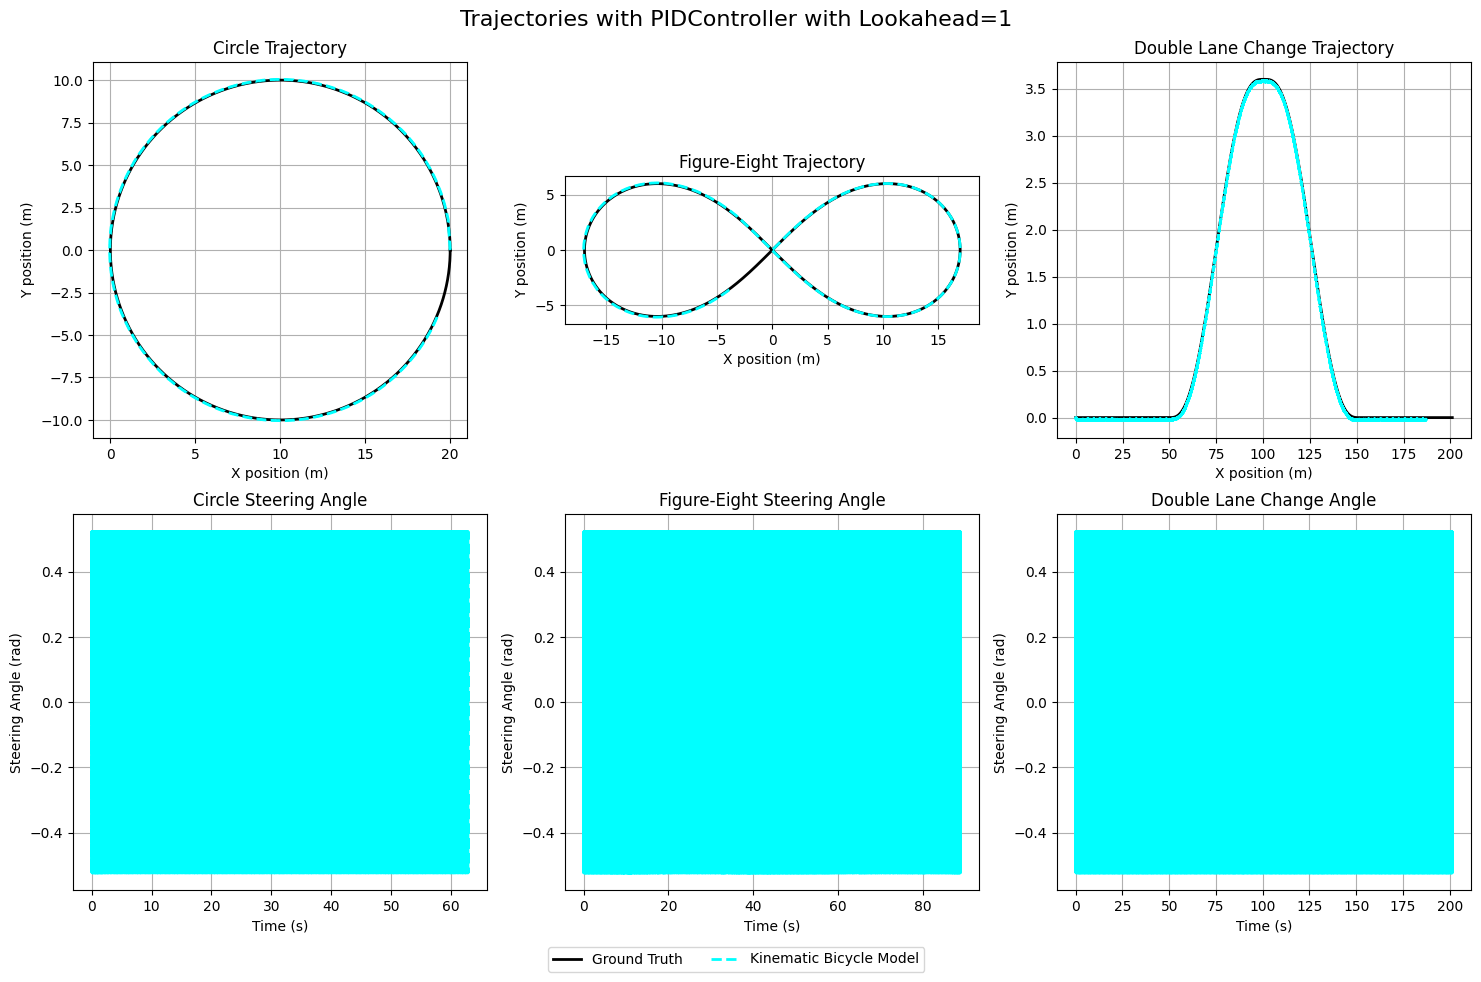

StanleyController


100%|██████████| 20136/20136 [00:04<00:00, 4842.15it/s]


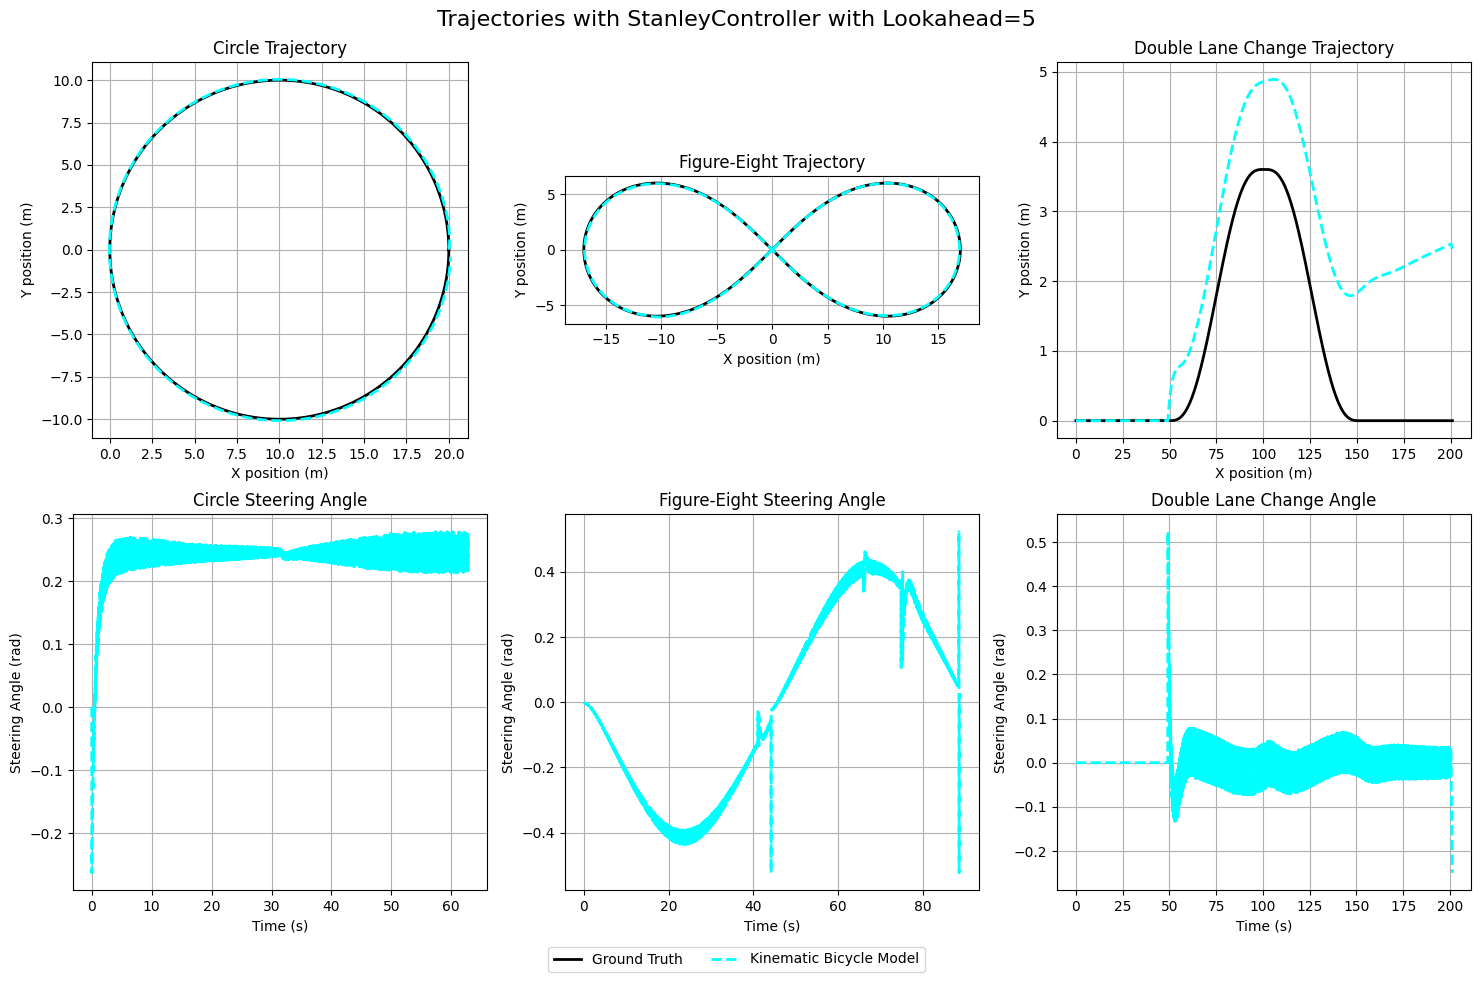

100%|██████████| 20136/20136 [00:04<00:00, 4539.25it/s]


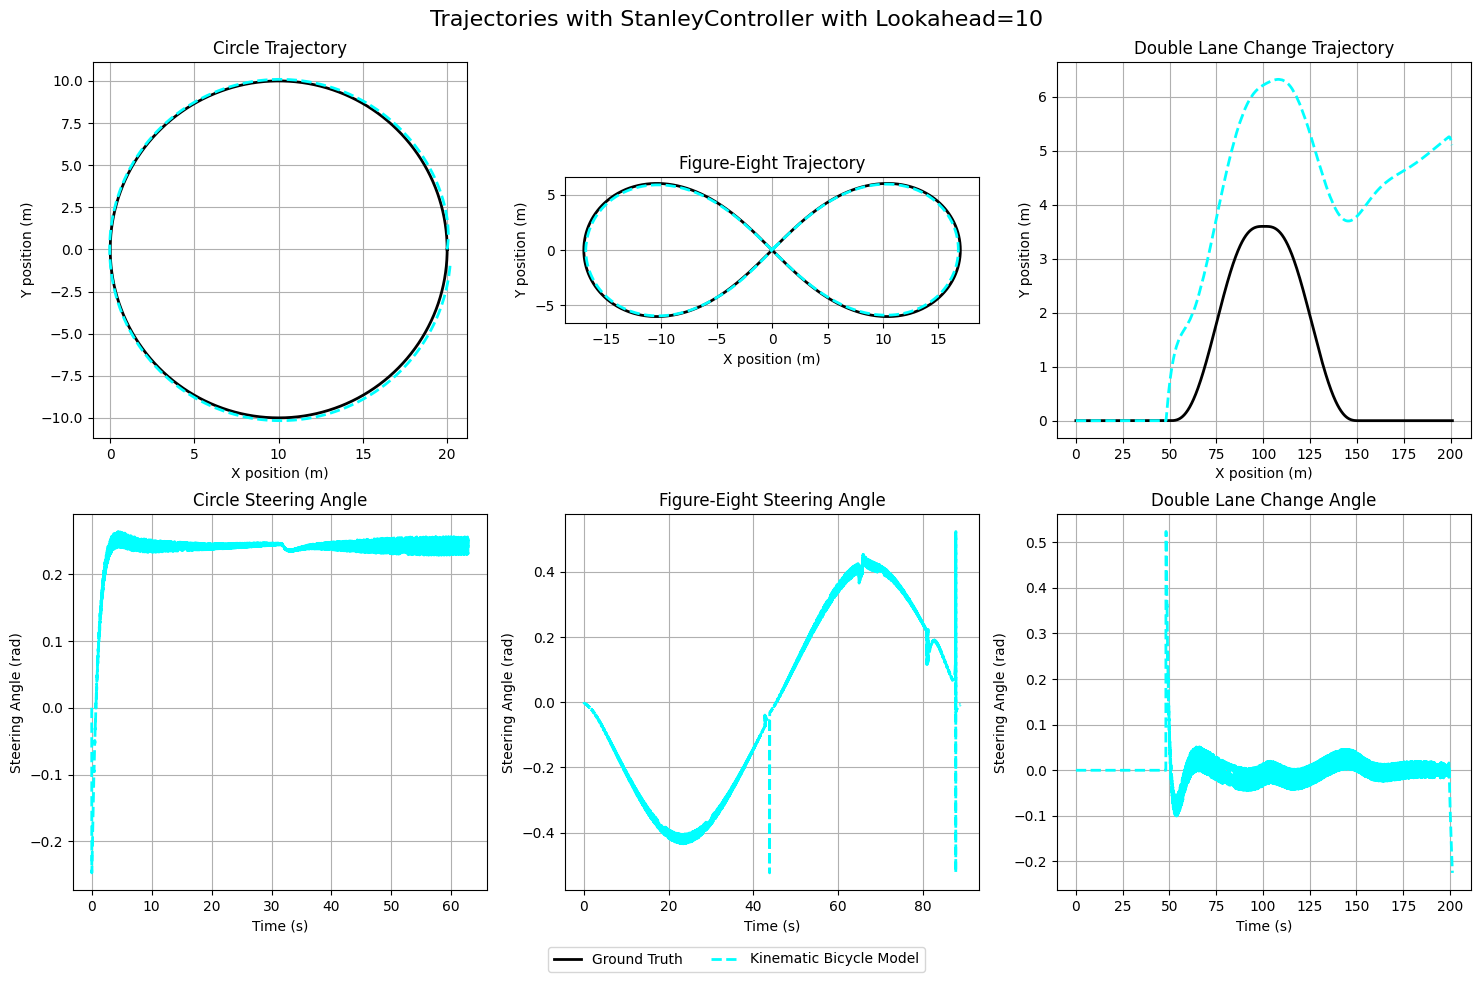

PurePursuitController


100%|██████████| 20136/20136 [00:03<00:00, 6020.56it/s]


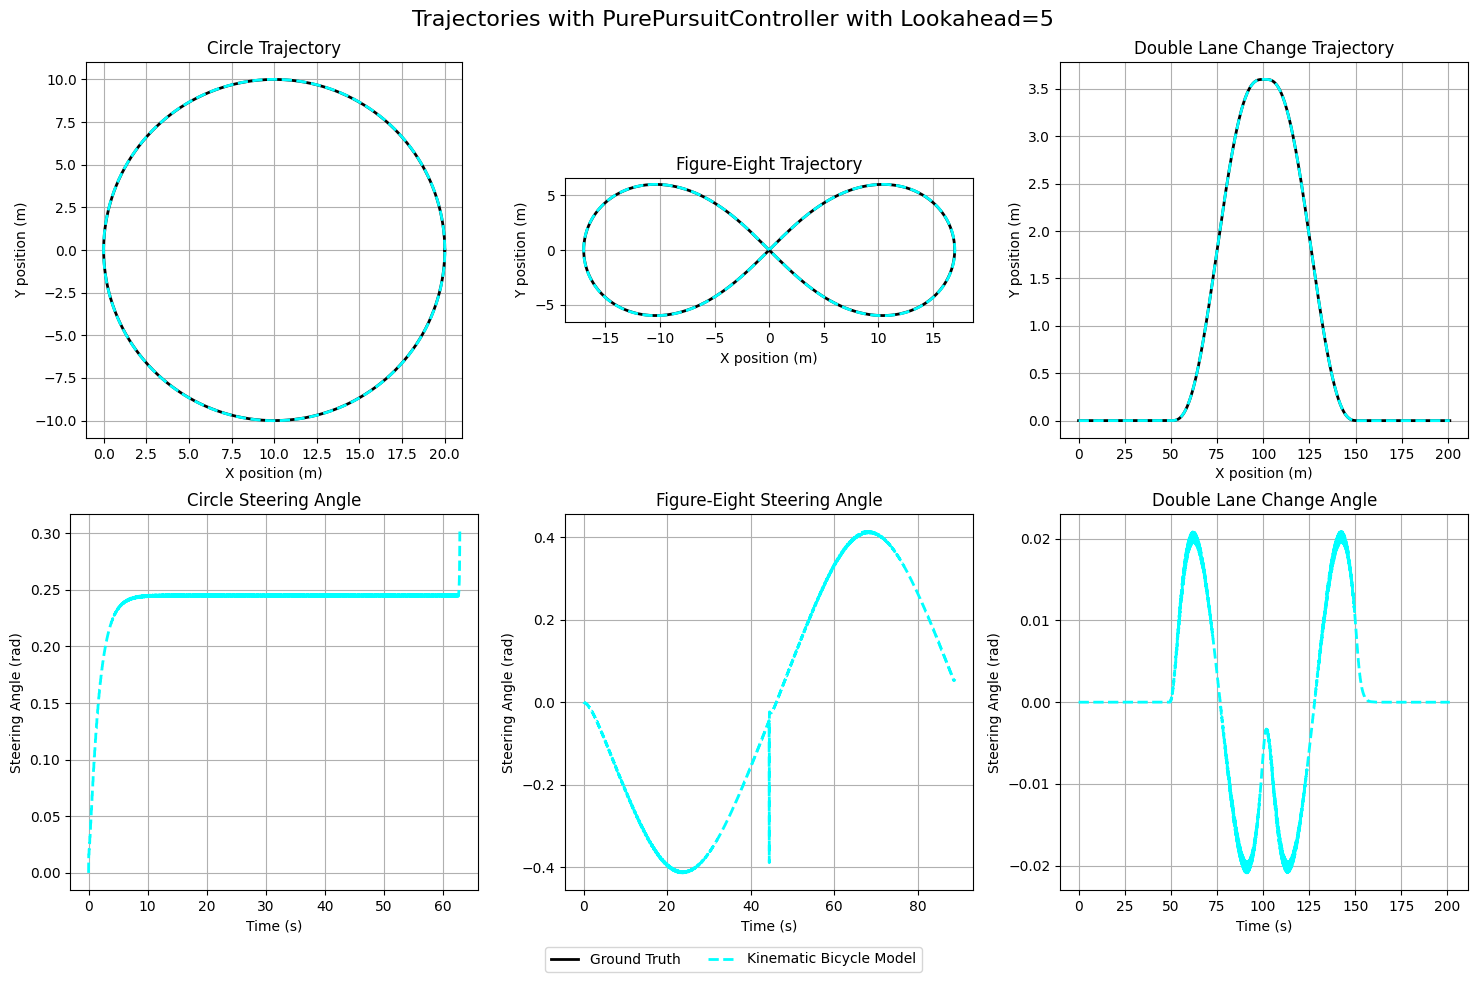

100%|██████████| 20136/20136 [00:03<00:00, 5780.48it/s]


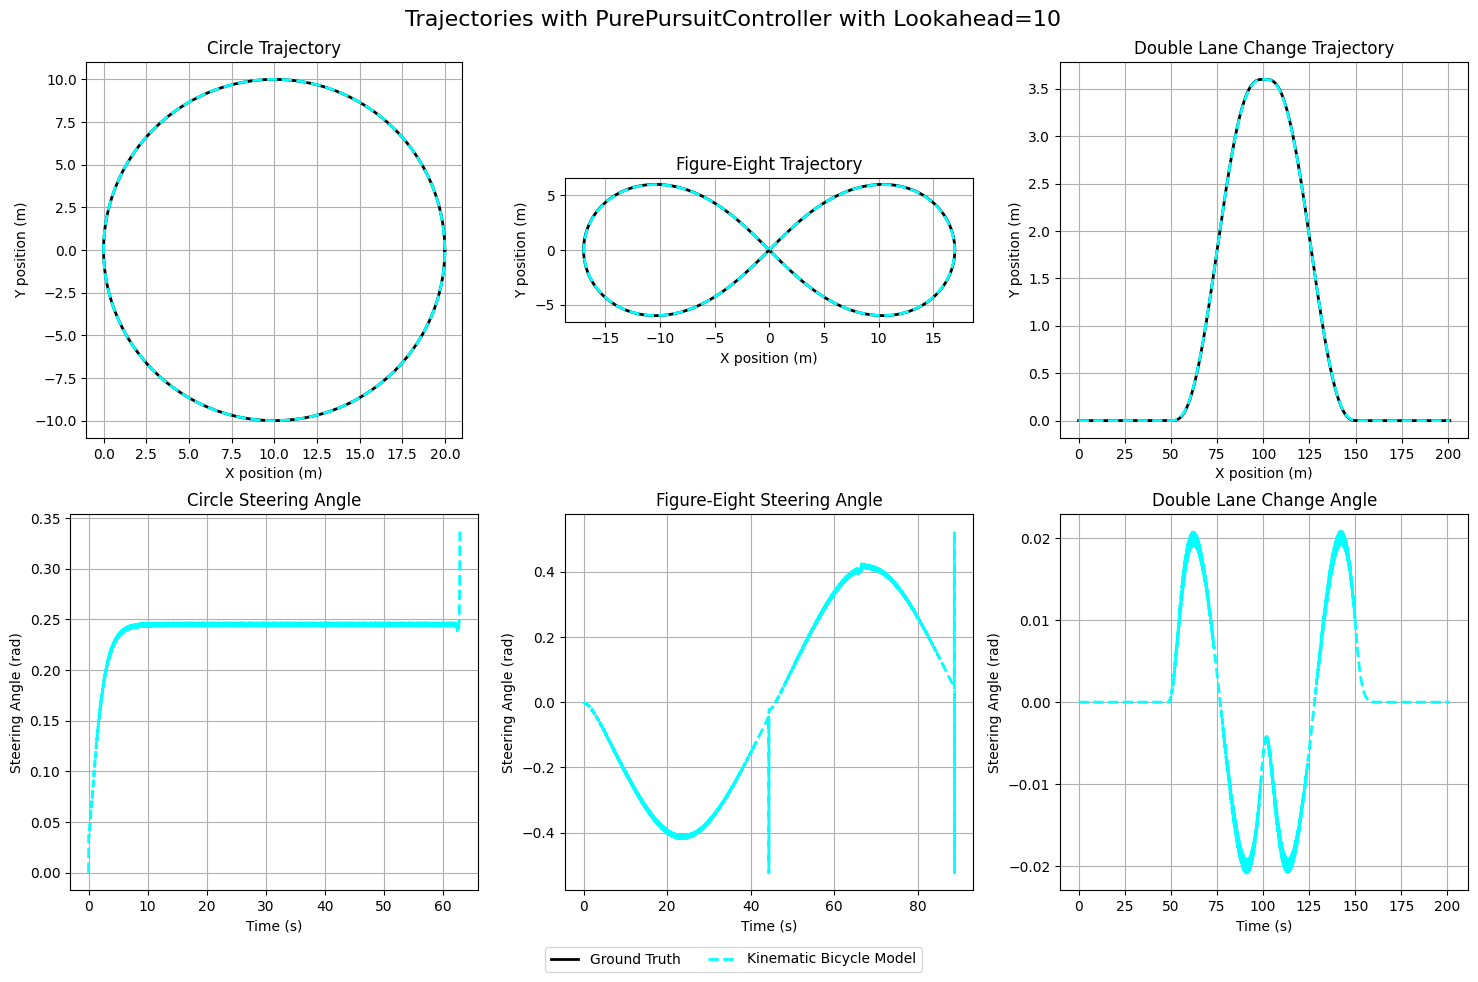

MPC


100%|██████████| 20136/20136 [01:27<00:00, 231.40it/s]


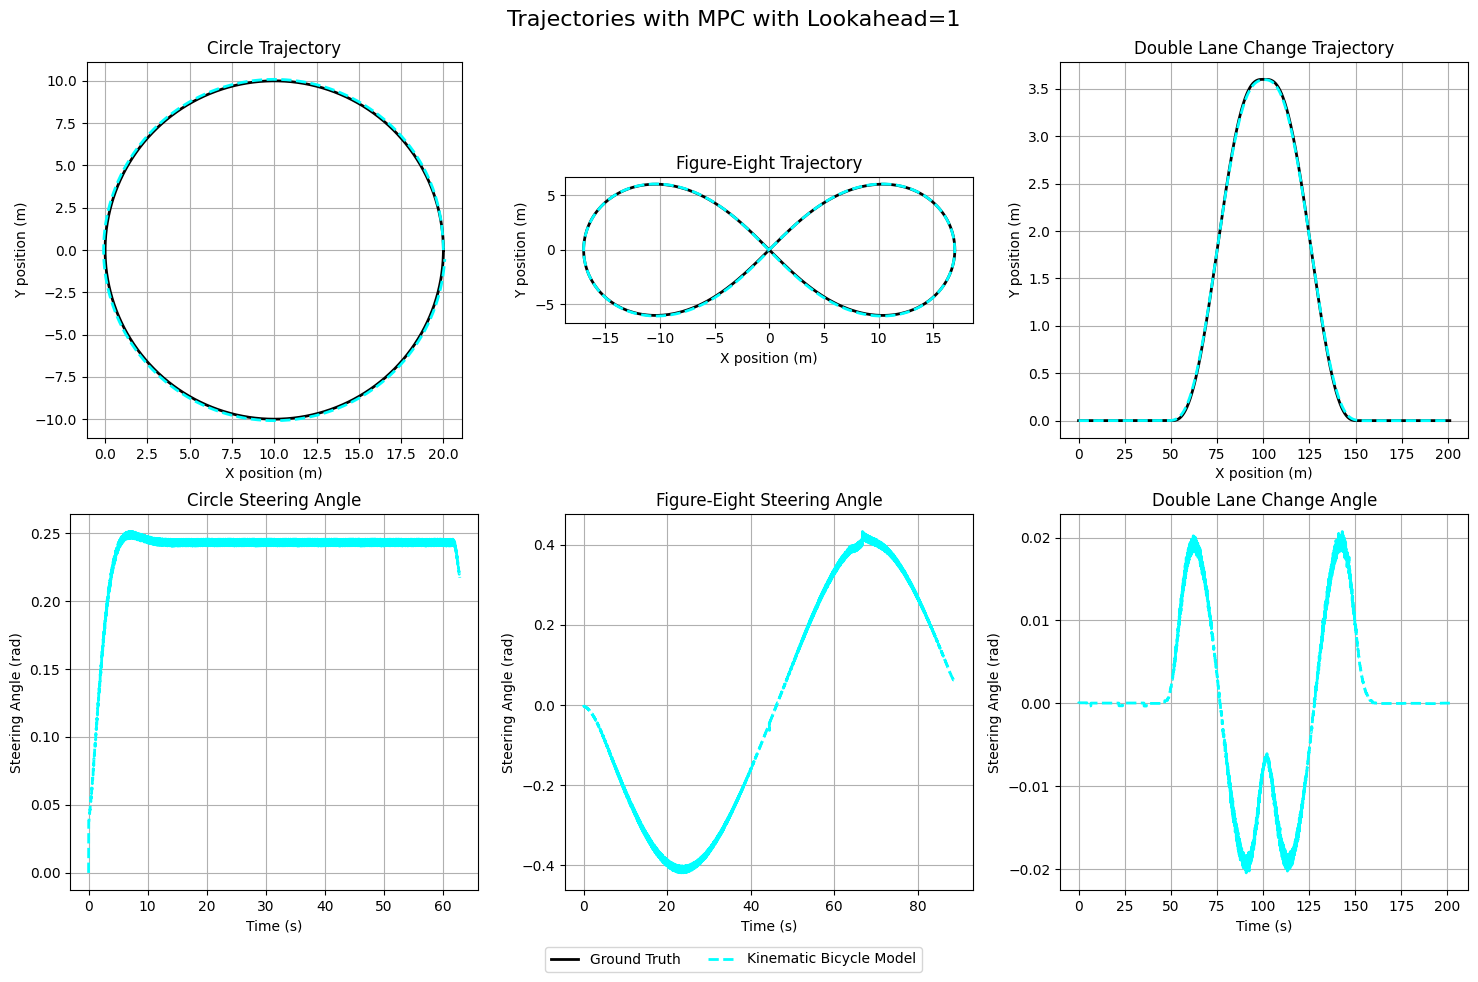

In [12]:
#-------#
# Model #
L = 2.5
lr = 1.7
dt = 0.01
v = 1

kin_model = KinematicBicycleModel(L=L, lr=lr, dt=dt)

#---------------------------#
# Reference Path Parameters #
NUM_POINTS = 1000
# Circle #
R = 10  # Radius of Circle
# Fig 8 #
A=12  # Diameter of Figure 8
# Double Lane Change #
LANE_WIDTH = 3.6
LANE_CHANGE_DISTANCE = 50
STRAIGHT_DISTANCE = 1

#-------------#
# Controllers #
PID = PIDController(kp=0.1, ki=0.04, kd=0.03, dt=dt)
Stanley = StanleyController(k=0.01)
PurePursuit = PurePursuitController(ld=1.60)
MPControl = MPC(model=kin_model, u_max=kin_model.max_delta, dt=dt, n_horizon=25, const_vel=True, reference_speed=v, max_iter=100)
controllers = [PID, Stanley, PurePursuit, MPControl]

for controller in controllers:
    print(controller.__class__.__name__)
    lookaheads = [5, 10] if type(controller) == StanleyController or type(controller) == PurePursuitController else [1]
    for N in lookaheads:
        #--------#
        # Circle #
        circular_gt = circle_trajectory(R=R, num_points=NUM_POINTS)
        simulation_steps = int(total_distance(circular_gt[0], circular_gt[1]) / (v * dt))
        initial_theta = np.arctan2(circular_gt[1][1] - circular_gt[1][0], circular_gt[0][1] - circular_gt[0][0])

        kin_model.initialize(x=circular_gt[0][0], y=circular_gt[1][0], theta=initial_theta)
        kin_circular_states = simulate(kin_model, circular_gt[0], circular_gt[1], desired_speed=v, controller=controller, num_steps=simulation_steps, base_lookahead_distance=1, N=N)
        x_traj_11, y_traj_11, theta_11, v_11, delta_11, beta_11 = zip(*kin_circular_states)
        kin_model.reset()

        #----------#
        # Figure 8 #
        figure8_gt = figure_eight_trajectory(a=A, num_points=NUM_POINTS)
        simulation_steps_fig8 = int(total_distance(figure8_gt[0], figure8_gt[1]) / (v * dt))
        initial_theta = np.arctan2(figure8_gt[1][1] - figure8_gt[1][0], figure8_gt[0][1] - figure8_gt[0][0])

        kin_model.initialize(x=figure8_gt[0][0], y=figure8_gt[1][0], theta=initial_theta)
        kin_fig8_states = simulate(kin_model, figure8_gt[0], figure8_gt[1], desired_speed=v, controller=controller, num_steps=simulation_steps_fig8, base_lookahead_distance=1, N=N)
        x_traj_12, y_traj_12, theta_12, v_12, delta_12, beta_12 = zip(*kin_fig8_states)
        kin_model.reset()

        #--------------------#
        # Double Lane Change #
        double_gt = double_lane_change_trajectory(lane_width=LANE_WIDTH, lane_change_distance=LANE_CHANGE_DISTANCE, straight_distance=STRAIGHT_DISTANCE, num_points=NUM_POINTS)
        simulation_steps_double = int(total_distance(double_gt[0], double_gt[1]) / (v * dt))

        kin_model.initialize(x=double_gt[0][0], y=double_gt[1][0])
        kin_double_states = simulate(kin_model, double_gt[0], double_gt[1], desired_speed=v, controller=controller, num_steps=simulation_steps_double, base_lookahead_distance=1, N=N)
        x_traj_13, y_traj_13, theta_13, v_13, delta_13, beta_13 = zip(*kin_double_states)
        kin_model.reset()

        #-------#
        # Plots #
        # Define the colors and line styles
        colors = ['black', 'cyan']
        line_styles = ['-', '--']
        labels = ['Ground Truth', 'Kinematic Bicycle Model']
        # Create a list of mlines.Line2D objects
        line_objects = [mlines.Line2D([], [], color=color, linestyle=line_style, linewidth=2) for color, line_style in zip(colors, line_styles)]
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Trajectories with {controller.__class__.__name__} with Lookahead={N}', fontsize=16)

        # Circle
        ax[0][0].plot(circular_gt[0], circular_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle=line_styles[0])
        ax[0][0].plot(x_traj_11, y_traj_11, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[0][0].set_title('Circle Trajectory')
        ax[0][0].set_xlabel('X position (m)')
        ax[0][0].set_ylabel('Y position (m)')
        ax[0][0].set_aspect('equal')
        ax[0][0].grid(True)

        ax[1][0].plot(np.arange(0, len(x_traj_11) * dt, dt), delta_11, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[1][0].set_title('Circle Steering Angle')
        ax[1][0].set_xlabel('Time (s)')
        ax[1][0].set_ylabel('Steering Angle (rad)')
        ax[1][0].grid(True)


        # Figure 8
        ax[0][1].plot(figure8_gt[0], figure8_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle=line_styles[0])
        ax[0][1].plot(x_traj_12, y_traj_12, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[0][1].set_title('Figure-Eight Trajectory')
        ax[0][1].set_xlabel('X position (m)')
        ax[0][1].set_ylabel('Y position (m)')
        ax[0][1].grid(True)
        ax[0][1].set_aspect('equal')

        ax[1][1].plot(np.arange(0, len(x_traj_12) * dt, dt), delta_12, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[1][1].set_title('Figure-Eight Steering Angle')
        ax[1][1].set_xlabel('Time (s)')
        ax[1][1].set_ylabel('Steering Angle (rad)')
        ax[1][1].grid(True)


        # Double Lane Change
        ax[0][2].plot(double_gt[0], double_gt[1], label='GroundTruthModel', color='black', linewidth=2, linestyle=line_styles[0])
        ax[0][2].plot(x_traj_13, y_traj_13, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[0][2].set_title('Double Lane Change Trajectory')
        ax[0][2].set_xlabel('X position (m)')
        ax[0][2].set_ylabel('Y position (m)')
        ax[0][2].grid(True)

        ax[1][2].plot(np.arange(0, len(x_traj_13) * dt, dt), delta_13, label='KinematicBicycleModel', color='cyan', linewidth=2, linestyle=line_styles[1])
        ax[1][2].set_title('Double Lane Change Angle')
        ax[1][2].set_xlabel('Time (s)')
        ax[1][2].set_ylabel('Steering Angle (rad)')
        ax[1][2].grid(True)

        fig.legend(handles=line_objects, labels=labels, loc='upper center', 
            bbox_to_anchor=(0.5, 0.05), ncol=4)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)
        plt.show()